### Import relevant library

In [3]:
import os
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import clustering_slidwin as clustering
from nilearn.plotting import plot_roi
from nilearn.image import load_img
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

importlib.reload(clustering)

from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
sns.set_style("whitegrid", {"axes.facecolor": "0.95"})

### Load input data

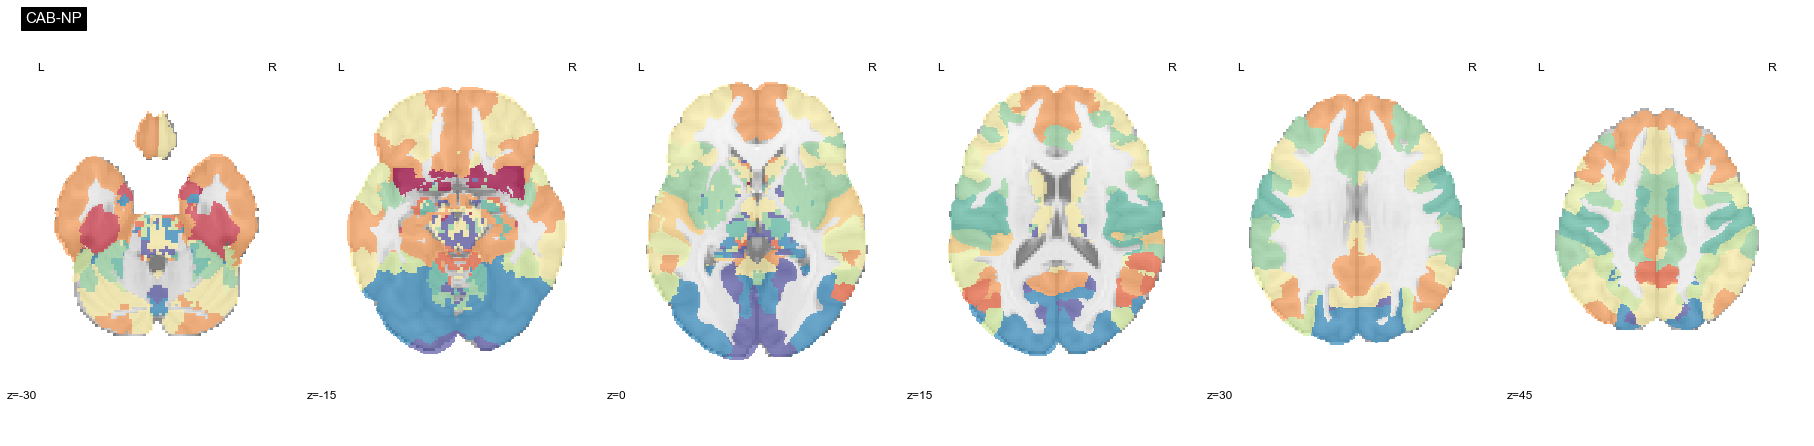

In [16]:
connectomes_matrices_extracted_dirpath = '../../connectomes_extraction_multi_TR/connectomes_matrix/updated_matrices/'
datasets_names_list = os.listdir(connectomes_matrices_extracted_dirpath)
delta_t = '300'
slidin_win = '0'

atlas_name = 'CAB-NP'
atlas = load_img(r'../../../atlas/CAB-NP_volumetric/CAB-NP_volumetric_liberal.nii.gz')

fig = plt.figure(figsize=(25,6))
plot_roi(atlas,
        display_mode='z',
        cut_coords=[-30,-15,0,15,30,45],
        title = atlas_name,
        figure=fig,
        annotate=True,
        draw_cross=False,
        black_bg=False,
        colorbar=False,
        vmin=0.8,
        vmax=12+0.2,
        cmap='Spectral_r'
                    )

### Participants information

In [10]:
datasets_participants_info_list = []
for dataset_name in datasets_names_list:
    participants_info_per_dataset = clustering.get_dataset_participants_info_tsv(connectomes_matrices_extracted_dirpath,
                                                                                dataset_name)
    datasets_participants_info_list.append(participants_info_per_dataset)

participants_info_concat = pd.concat(datasets_participants_info_list, axis=0, join='inner')
participants_info_merged = clustering.merge_datasets_participants_info(datasets_participants_info_list)
participants_info_merged.describe(include='all')

,sex,age,dataset
count,66,66.000000,66
unique,2,NaN,5
top,M,NaN,mdtb
freq,33,NaN,24
mean,NaN,29.045455,NaN
std,NaN,6.828519,NaN
min,NaN,19.000000,NaN
25%,NaN,24.000000,NaN
50%,NaN,27.000000,NaN
75%,NaN,33.750000,NaN


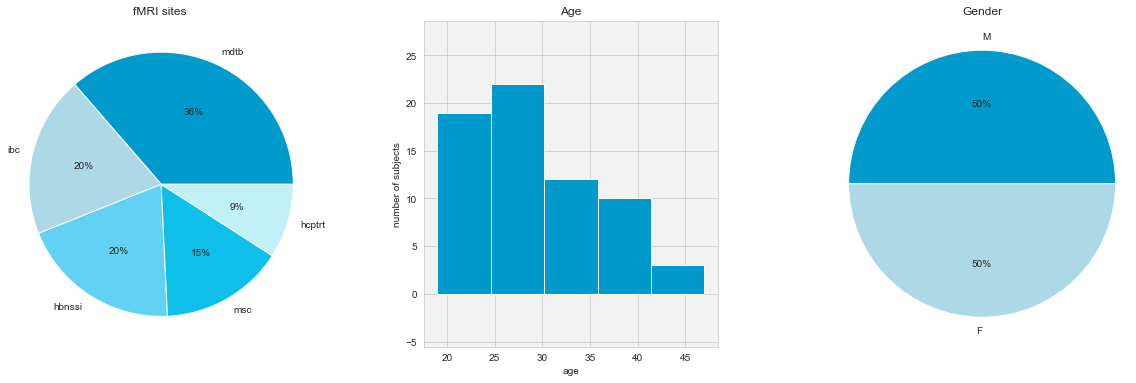

In [11]:
age = participants_info_merged['age']
gender_counts =  participants_info_merged['sex'].value_counts()
datasets_counts = participants_info_merged['dataset'].value_counts()

fig, axs= plt.subplots(1,3, figsize=(20,6))
fig.subplots_adjust(wspace=0.4);

color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9', '#C1F0F6', '#0099CC']

axs[0].pie(datasets_counts, labels=datasets_counts.index, colors = color_palette_list[:len(datasets_counts)],
           autopct='%1.0f%%', shadow=False, startangle=0);
axs[0].axis('equal');
axs[0].set_title('fMRI sites');

axs[1].hist(age, bins=5, color = color_palette_list[-1], label= age.index);
axs[1].set_title('Age');
axs[1].set_xlabel('age')
axs[1].set_ylabel('number of subjects')
axs[1].axis('equal');

axs[2].pie(gender_counts, labels=gender_counts.index, colors = color_palette_list[:len(gender_counts)], autopct='%1.0f%%',
       shadow=False, startangle=0);
axs[2].axis('equal');
axs[2].set_title('Gender');


### Data analysis

In [12]:
# regressors
dummies_variables_names = ['dataset']
participants_info_encoded = clustering.encoded_dummies_variables(participants_info_merged, dummies_variables_names)
regressors = participants_info_encoded.drop(columns=['sex','age'])

# pre-clustering inputs
scaler = StandardScaler()

<Figure size 432x432 with 0 Axes>

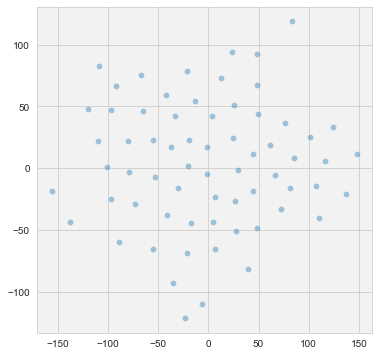

In [18]:
matricesFiles_path = clustering.get_minMatrix(connectomes_matrices_extracted_dirpath, datasets_names_list,
                                              atlas_name, slidin_win, delta_t)
matrixFile_path = matricesFiles_path[0]
connectomes_matrices = clustering.create_connMatrix(connectomes_matrices_extracted_dirpath, datasets_names_list, atlas_name, slidin_win, delta_t, matrixFile_path)
connectomes_matrices_residual = clustering.calcul_residualMatrix(regressors,connectomes_matrices)
connectomes_matrices_residual_scaled = scaler.fit_transform(X=connectomes_matrices_residual)

tsne_results = TSNE(n_components=2).fit_transform(connectomes_matrices_residual)
plt.figure(figsize=(6,6))
sns.scatterplot(x = tsne_results[:,0], y= tsne_results[:,1], palette='pastel', alpha=0.4)

Dimension reduction analysis

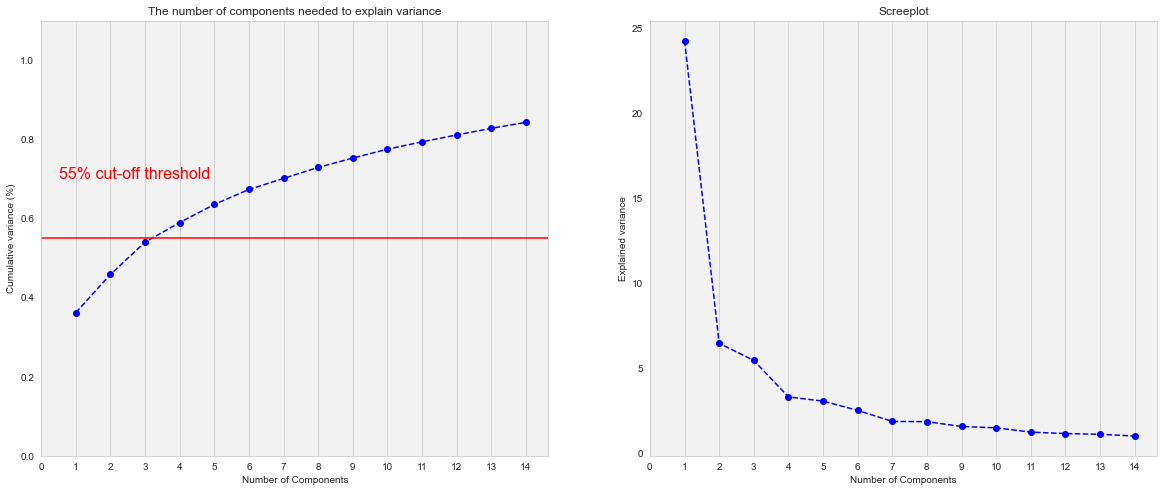

In [21]:
pca = PCA().fit(X=connectomes_matrices_residual_scaled)
fig, axs = plt.subplots(1,2, figsize=(20,8))
xi = np.arange(1, 15, step=1)
y = np.cumsum(pca.explained_variance_ratio_)[:len(xi)]
z = pca.explained_variance_[:len(xi)]

axs[0].set_ylim(0.0,1.1);
axs[0].plot(xi, y, marker='o', linestyle='--', color='b');
axs[0].set_xlabel('Number of Components');
axs[0].set_xticks(np.arange(0, 15, step=1)); #change from 0-based array index to 1-based human-readable label
axs[0].set_ylabel('Cumulative variance (%)');
axs[0].set_title('The number of components needed to explain variance');
axs[0].axhline(y=0.55, color='r', linestyle='-');
axs[0].text(0.5, 0.70, '55% cut-off threshold', color = 'red', fontsize=16);
axs[0].grid(axis='y');

axs[1].plot(xi, z, marker='o', linestyle='--', color='b');
axs[1].set_xlabel('Number of Components');
axs[1].set_xticks(np.arange(0, 15, step=1)); #change from 0-based array index to 1-based human-readable label
axs[1].set_ylabel('Explained variance');
axs[1].set_title('Screeplot');
axs[1].grid(axis='y');
plt.show();

Evaluation of the optimal cluster number for differents amount of variances

<Figure size 1080x360 with 0 Axes>

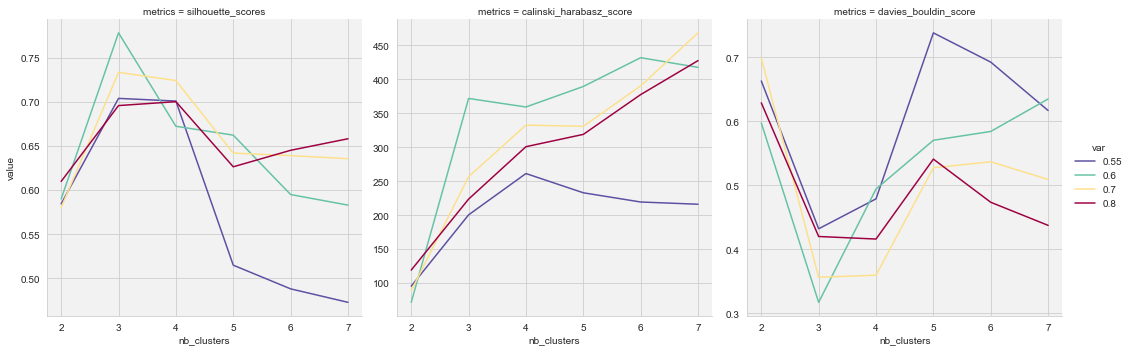

In [24]:
# clustering inputs
nb_cluster_min = 2
nb_cluster_max = 4
clusters_list = range(nb_cluster_min,nb_cluster_max+4)
variance_list = [0.55,0.6,0.7,0.8]

number_of_components_list = []
dispersion_metrics_list = []

for variance in variance_list:
    connectomes_matrices_residual_pca =  PCA(variance).fit_transform(X=connectomes_matrices_residual_scaled)

    clustering_labels_results = clustering.apply_clustering_methods(connectomes_matrices_residual_pca, nb_cluster_min,
                                                            nb_cluster_max)
    coocurence_matrix = clustering.calculate_coocurence_matrix(clustering_labels_results)
    coocurence_matrix_linked = linkage(coocurence_matrix, method='ward')
    #clusters = fcluster(coocurence_matrix_linked,opt_nb_cluster,criterion='maxclust')
    # sns.clustermap(coocurence_matrix, method='ward', col_cluster=True, cmap='YlOrRd', vmin=0, vmax=1)

    dispersion = pd.DataFrame(index = clusters_list)
    for nb_cluster in clusters_list:
        clusters_labels = fcluster(coocurence_matrix_linked,nb_cluster,criterion='maxclust')
        dispersion.loc[nb_cluster,'silhouette_scores'] = silhouette_score(coocurence_matrix, clusters_labels)
        dispersion.loc[nb_cluster,'calinski_harabasz_score'] = calinski_harabasz_score(coocurence_matrix, clusters_labels)
        dispersion.loc[nb_cluster,'davies_bouldin_score'] = davies_bouldin_score(coocurence_matrix, clusters_labels)
    dispersion = dispersion.astype('float')
    number_of_components_list.append(connectomes_matrices_residual_pca.shape[1])
    dispersion_metrics_list.append(dispersion)

dispersion_metrics = pd.concat(dispersion_metrics_list, keys=variance_list)
dispersion_metrics_index_reseted = dispersion_metrics.reset_index()
dispersion_metrics_index_reseted = dispersion_metrics_index_reseted.rename(columns= {'level_0':'var',
                                                                                     'level_1':'nb_clusters'})

dispersion_melt= pd.melt(dispersion_metrics_index_reseted, id_vars=['nb_clusters', 'var' ], var_name='metrics',
                         value_name='value')

fig=plt.figure(figsize=(15,5))
sns.relplot(data=dispersion_melt ,x='nb_clusters', y='value', hue='var', col='metrics', col_wrap=3, kind='line',
            palette= 'Spectral_r', facet_kws={'sharex':False, 'sharey':False})